In [81]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import pylab as plt
import xarray as xr
import seaborn as sns
import nc_time_axis
from joblib import Parallel, delayed
from tqdm import tqdm
import joblib
import contextlib
from scipy.signal import savgol_filter
from glob import glob
from functools import reduce
import matplotlib.colors as colors
import matplotlib.cm as cmx


In [82]:
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""

    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        """TQDM Callback"""

        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()


In [83]:
df = pd.read_csv("kennicott-profile.csv")

In [84]:
x = df["x"].values
surface = df["elevation"].values
x = np.hstack([x, 60e3])
surface = np.hstack([surface, 200])

In [85]:
dx = 100
Lx = 60e3
nx = int(Lx / dx)
x_new = np.linspace(dx, Lx, nx)
f = interp1d(x, surface, kind="quadratic")
surface_new = f(x_new)

In [86]:
surface_filtered = savgol_filter(surface_new, window_length=6, polyorder=5, mode="interp")

(0.0, 10000.0)

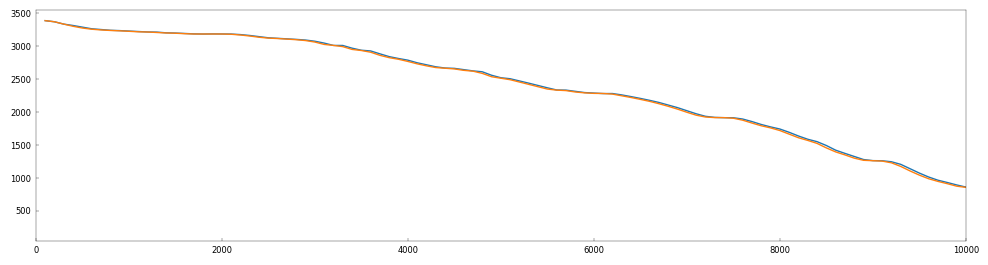

In [87]:
fig = plt.figure(figsize=[12, 3])
ax = fig.add_subplot(111)
ax.plot(x_new, surface_new)
ax.plot(x_new, surface_filtered)
ax.set_xlim(0, 10e3)

In [88]:
df_new = pd.DataFrame(data=np.vstack([x_new, surface_new, surface_new]).T, columns=["x", "bed", "surface"])

In [89]:
df_new.to_csv("kennicott-profile-100m.csv")

In [113]:
uq_df = pd.read_csv("ensemble_kennicott_climate_flow_lhs_1000.csv")

In [114]:
def process_ensemble(m_file, params_df):
    with xr.open_dataset(m_file) as ds:
        m_id = int(m_file.split(".")[0].split("_")[-3])
        x = ds["x"]
        bed = ds["topg"][-1,-1,:]
        thickness = ds["thk"][-1,-1,:]
        surface = ds["usurf"][-1,-1,:]
        surface_speed = ds["velsurf_mag"][-1,-1,:]
        surface_speed = surface_speed.where(thickness>10)
        basal_speed = ds["velbase_mag"][-1,-1,:]
        basal_speed = basal_speed.where(thickness>10)
        temp_pa = ds["temp_pa"][-1,-1,:, 0]
        temp_pa = temp_pa.where(thickness>10)
        params = params_df[params_df["id"] == m_id]
        ela =  params["ela"].values[0]
        try:
            f = interp1d(surface, x)
            x_ela = f(ela)
        except:
            pass
        try:
            f = interp1d(x, thickness)
            thickness_ela = f(x_ela)
        except:
            thickness_ela = np.nan
        try:
            f = interp1d(x, surface_speed)
            surface_speed_ela = f(x_ela)
        except:
            surface_speed_ela = np.nan
        try:
            f = interp1d(x, basal_speed)
            basal_speed_ela = f(x_ela)
        except:
            basal_speed_ela = np.nan
        try:
            f = interp1d(x, temp_pa)
            temp_pa_ela = f(x_ela)
        except:
            temp_pa_ela = np.nan
        log_like = 0.0
        try:
            idx = np.where(thickness.where(surface<3000)[:].values == 0)[0]
            if len(idx) != 0:
                exp = x.to_numpy()[idx[0]]
                log_like -= 0.5 * (
                    (exp - observed_mean) / observed_std
                    ) ** 2 + 0.5 * np.log(2 * np.pi * observed_std**2)
        except ValueError:
            pass
    d =  {"id": m_id, 
            "data": {"x": x, 
                     "thickness": thickness.to_numpy(),
                     "bed": bed.to_numpy(),
                     "surface": surface.to_numpy(), 
                     "surface_speed": surface_speed.to_numpy(), 
                     "basal_speed": basal_speed.to_numpy(), 
                     "temp_pa": temp_pa.to_numpy(), 
                     "ela": ela,
                     "thickness_ela": thickness_ela,
                     "surface_speed_ela": surface_speed_ela,
                     "basal_speed_ela": basal_speed_ela}}
    if log_like != 0:
        d["data"]["log_like"] = log_like
    return d
   

In [115]:
fontsize = 6
lw = 1.0
aspect_ratio = 1
markersize = 1

params = {
    "backend": "ps",
    "axes.linewidth": 0.25,
    "lines.linewidth": lw,
    "axes.labelsize": fontsize,
    "font.size": fontsize,
    "xtick.direction": "in",
    "xtick.labelsize": fontsize,
    "xtick.major.size": 2.5,
    "xtick.major.width": 0.25,
    "ytick.direction": "in",
    "ytick.labelsize": fontsize,
    "ytick.major.size": 2.5,
    "ytick.major.width": 0.25,
    "legend.fontsize": fontsize,
    "lines.markersize": markersize,
    "font.size": fontsize,
}

plt.rcParams.update(params)
cmap = sns.color_palette("colorblind")

In [116]:
observed_mean = 20_000
observed_std = 1000

odir = "2023_06_23_uq_climate_flow/"

m_files = glob(f"{odir}/state/kennicott_*.nc")
n_files = len(m_files)
n_jobs = 4

In [117]:
        with tqdm_joblib(tqdm(desc="Processing ensemble", total=n_files)) as progress_bar:
            df = Parallel(n_jobs=n_jobs)(
                delayed(process_ensemble)(
                    m_file, uq_df
                )
                for m_file in m_files
            )
            del progress_bar


Processing ensemble: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 51.86it/s]


In [118]:
thickness_ela_df = pd.concat([pd.DataFrame(data=np.vstack([df[m]["id"], df[m]["data"]["thickness_ela"]]).T, columns=["id", "thickness_ela"]) for m in range(len(df))])
surface_speed_ela_df = pd.concat([pd.DataFrame(data=np.vstack([df[m]["id"], df[m]["data"]["surface_speed_ela"]]).T, columns=["id", "surface_speed_ela"]) for m in range(len(df))])
basal_speed_ela_df = pd.concat([pd.DataFrame(data=np.vstack([df[m]["id"], df[m]["data"]["basal_speed_ela"]]).T, columns=["id", "basal_speed_ela"]) for m in range(len(df))])

dfs = [uq_df, thickness_ela_df, surface_speed_ela_df, basal_speed_ela_df]

all_glaciers_df = reduce(lambda  left,right: pd.merge(left,right,on=["id"],
                                            how='outer'), dfs).reset_index(drop=True)
#all_glaciers_df = pd.merge(uq_df, thickness_ela_df, on="id").reset_index(drop=True)

In [119]:
ids = np.array([d["id"] for d in df if d["data"]["thickness"][-1] < 10]).T
X = np.array([d["data"]["x"] for d in df if d["data"]["thickness"][-1] < 10]).T
Bed = np.array([d["data"]["bed"] for d in df if d["data"]["thickness"][-1] < 10]).T
Surface = np.array([d["data"]["surface"] for d in df if d["data"]["thickness"][-1] < 10]).T
Thickness = np.array([d["data"]["thickness"] for d in df if d["data"]["thickness"][-1] < 10]).T
Surface_speed = np.array([d["data"]["surface_speed"] for d in df if d["data"]["thickness"][-1] < 10]).T
Basal_speed = np.array([d["data"]["basal_speed"] for d in df if d["data"]["thickness"][-1] < 10]).T
Temp_pa = np.array([d["data"]["temp_pa"] for d in df if d["data"]["thickness"][-1] < 10]).T

ids_l = np.array([d["id"] for d in df if d["data"]["thickness"][-1] >= 10]).T
X_l = np.array([d["data"]["x"] for d in df if d["data"]["thickness"][-1] >= 10]).T
Surface_l = np.array([d["data"]["surface"] for d in df if d["data"]["thickness"][-1] >= 10]).T
Thickness_l = np.array([d["data"]["thickness"] for d in df if d["data"]["thickness"][-1] >= 10]).T
Surface_peed_l = np.array([d["data"]["surface_speed"] for d in df if d["data"]["thickness"][-1] >= 10]).T
Basal_speed_l = np.array([d["data"]["basal_speed"] for d in df if d["data"]["thickness"][-1] >= 10]).T
Temp_pa_l = np.array([d["data"]["temp_pa"] for d in df if d["data"]["thickness"][-1] >= 10]).T


log_likes = np.array([d["data"]["log_like"] for d in df if "log_like" in d["data"]]).T
id_log_likes = np.array([d["id"] for d in df if "log_like" in d["data"]]).T



In [120]:
experiments = np.array(id_log_likes)
w = np.array(log_likes)
w -= w.mean()
weights = np.exp(w)
weights /= weights.sum()
resampled_experiments = np.random.choice(experiments, len(experiments), p=weights)

In [121]:
resampled_df = pd.DataFrame(data=np.vstack([experiments, weights]).T, columns=["id", "weight"])
all_glaciers_with_weights = pd.merge(all_glaciers_df, resampled_df, on="id", how="outer").fillna(0)
weights_min = all_glaciers_with_weights["weight"].min()
weights_max = all_glaciers_with_weights["weight"].max()

cmap = plt.get_cmap("magma")
cNorm = colors.Normalize(vmin=weights_min, vmax=weights_max)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
colorVals = scalarMap.to_rgba(range(len(uq_df)))


AttributeError: 'numpy.ndarray' object has no attribute 'Normalize'

/var/folders/pb/9bmdq04j7h9126gzz9zd3b_80000gn/T/ipykernel_8907/950660210.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cbar = plt.cm.get_cmap("magma")


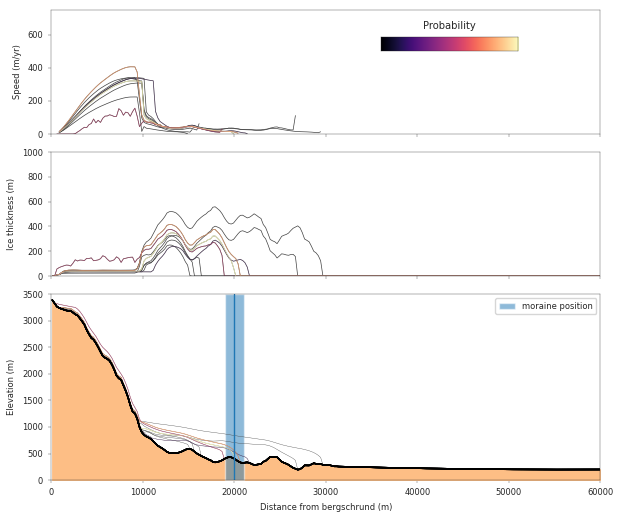

In [122]:
with sns.axes_style("ticks"): 
    fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=[6.2, 5.2], height_ratios=[2, 2, 3])
    fig.subplots_adjust(bottom=0, top=1, left=0, right=1, wspace=0, hspace=0)
    
    cbar = plt.cm.get_cmap("magma")
    colors = cbar(np.arange(cbar.N))
    cax = axs[0].inset_axes([0.6, 0.6, 0.25, 0.25])
    cax.imshow([colors], extent=[0, 10, 0, 1])
    cax.set_title("Probability")
    cax.set_xticks([])
    cax.set_yticks([])
    axs[0].plot(X_l, Surface_peed_l, color="0.75", lw=0.25)
    axs[0].plot(X, Surface_speed, color="0.25", lw=0.5)
    axs[1].plot(X_l, Thickness_l, color="0.75", lw=0.25)
    axs[1].plot(X, Thickness, color="0.25", lw=.5)
    axs[-1].plot(X_l, Surface_l, color="0.75", lw=0.25)
    axs[-1].plot(X, Surface, color="0.25", lw=0.25)
    for k in range(len(ids)):
        m_id = ids[k]
        w = all_glaciers_with_weights[all_glaciers_with_weights["id"] == int(m_id)]["weight"].values[0]
        axs[0].plot(X[:, k], Surface_speed[:, k], 
                     color=cmap(w / (weights_max-weights_min)), 
                     alpha=w / (weights_max-weights_min), 
                     lw=0.5)
        axs[1].plot(X[:, k], Thickness[:, k], 
                     color=cmap(w / (weights_max-weights_min)), 
                     alpha=w / (weights_max-weights_min), 
                     lw=0.5)
        axs[-1].plot(X[:, k], Surface[:, k], 
                     color=cmap(w / (weights_max-weights_min)), 
                     alpha=w / (weights_max-weights_min), 
                     lw=0.5)
    axs[-1].plot(X, Bed[:, 0], color="k")
    axs[-1].fill_between(X[:, 0], np.zeros_like(Bed[:, 0]), Bed[:, 0], color="#fdbe85")
    axs[-1].fill_betweenx([0, 3500], observed_mean-observed_std, 
                          observed_mean+observed_std, alpha=0.5, label="moraine position")
    axs[-1].axvline(observed_mean)
    axs[0].set_ylabel("Speed (m/yr)")
    axs[0].set_ylim(0, 750)
    axs[1].set_ylim(0, 1000)
    axs[-1].set_ylim(0, 3500)
    axs[-1].set_xlim(0, 60000)
    axs[1].set_ylabel("Ice thickness (m)")
    axs[-1].set_ylabel("Elevation (m)")
    axs[-1].set_xlabel("Distance from bergschrund (m)")
    axs[-1].legend()
    fig.tight_layout()
    fig.savefig(f"{odir}/kennicott_profile_plot.pdf")


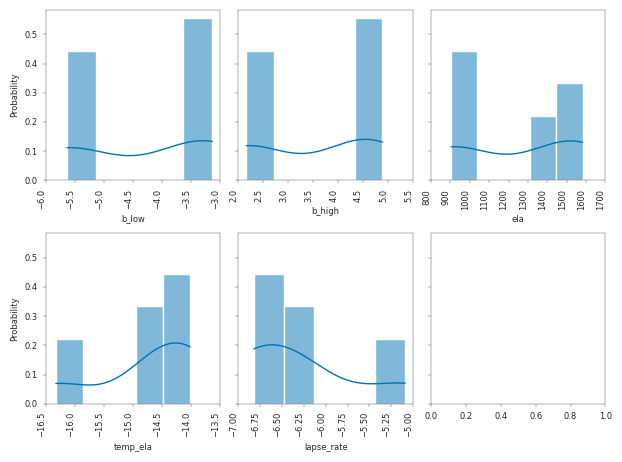

In [123]:
d = []
for e in resampled_experiments:
    d.append(uq_df[uq_df["id"] == int(e)])
moraine_glaciers_df = pd.concat(d).reset_index(drop=True)

with sns.axes_style("ticks"):
    sns_cmap = sns.color_palette("colorblind")
    fig, axs = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=[6.2, 4.6])
    fig.subplots_adjust(bottom=0, top=1, left=0, right=1, wspace=-1, hspace=-1)
    for k, v in enumerate(["b_low", "b_high", "ela", "temp_ela", "lapse_rate"]):
        sns.histplot(data=moraine_glaciers_df, x=v, kde=True,
                     color=sns_cmap[0],
                     stat="probability", ax=axs.ravel()[k])
        axs.ravel()[k].set_xticks(axs.ravel()[k].get_xticks(), 
                                  axs.ravel()[k].get_xticklabels(), 
                                  rotation=90, ha='right')

fig.tight_layout()
fig.savefig("2023_06_21_uq_climate/kennicott_hists.pdf")

In [124]:
m_df = pd.DataFrame(data=np.vstack([experiments, weights]).T, columns=["id", "weight"])
a_df = pd.DataFrame(data=np.vstack([experiments, np.ones_like(experiments) / len(experiments)]).T, columns=["id", "weight"])

In [125]:
mm_df = pd.merge(all_glaciers_df, m_df, on="id")
mm_df["Exp"] = "Moraine"
aa_df = pd.merge(all_glaciers_df, a_df, on="id")
aa_df["Exp"] = "All"

In [126]:
am_df = pd.concat([mm_df, aa_df]).reset_index(drop=True)

/opt/local/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/distributions.py:407: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/local/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/distributions.py:407: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/local/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/distributions.py:407: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


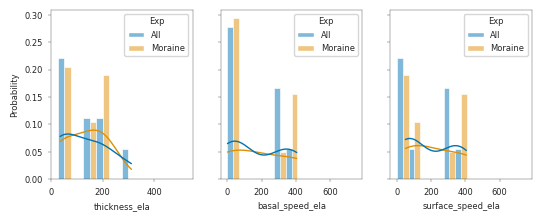

In [127]:
with sns.axes_style("ticks"):
    fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(6.2, 2.2))
    g = sns.histplot(data=am_df, x="thickness_ela", weights="weight", hue_order=["All", "Moraine"],
                 bins=np.linspace(25, 525, 11), palette="colorblind",
                 hue="Exp", stat="probability", 
                 multiple="dodge", kde=True, kde_kws={"clip": [None, 525]}, ax=axs[0])
    g = sns.histplot(data=am_df, x="basal_speed_ela", weights="weight", hue_order=["All", "Moraine"],
                 bins=np.linspace(0, 750, 12), palette="colorblind",
                 hue="Exp", stat="probability", 
                 multiple="dodge", kde=True, kde_kws={"clip": [None, 750]}, ax=axs[1])
    g = sns.histplot(data=am_df, x="surface_speed_ela", weights="weight", hue_order=["All", "Moraine"],
                 bins=np.linspace(0, 750, 12), palette="colorblind",
                 hue="Exp", stat="probability", 
                 multiple="dodge", kde=True, kde_kws={"clip": [None, 750]}, ax=axs[2])


In [128]:
all_glaciers_df["Exp"] = "All"
moraine_glaciers_df["Exp"] = "Moraine"
dfs = [moraine_glaciers_df, thickness_ela_df, basal_speed_ela_df, surface_speed_ela_df]
morain_glaciers_df = reduce(lambda  left,right: pd.merge(left,right,on=["id"],
                                            how='outer'), dfs).reset_index(drop=True)
#moraine_glaciers_df = pd.merge(moraine_glaciers_df, thickness_ela_df, on="id")
merged_df = pd.concat([all_glaciers_df, moraine_glaciers_df]).reset_index(drop=True)

In [129]:
median_df = merged_df.groupby(by="Exp").median()
mean_df = merged_df.groupby(by="Exp").mean()

In [130]:
[axs[0].axvline(median_df["thickness_ela"][e], color=sns_cmap[k], lw=.75) for k, e in enumerate(median_df.index)]
[axs[0].axvline(mean_df["thickness_ela"][e], color=sns_cmap[k], lw=.75, ls="dotted") for k, e in enumerate(mean_df.index)]
[axs[1].axvline(median_df["basal_speed_ela"][e], color=sns_cmap[k], lw=.75) for k, e in enumerate(median_df.index)]
[axs[1].axvline(mean_df["basal_speed_ela"][e], color=sns_cmap[k], lw=.75, ls="dotted") for k, e in enumerate(mean_df.index)]
[axs[2].axvline(median_df["surface_speed_ela"][e], color=sns_cmap[k], lw=.75) for k, e in enumerate(median_df.index)]
[axs[2].axvline(mean_df["surface_speed_ela"][e], color=sns_cmap[k], lw=0.75, ls="dotted") for k, e in enumerate(mean_df.index)]
fig.tight_layout()
fig.savefig("ela_pdfs.pdf")

In [131]:
d = []
for e in ids_l:
    d.append(uq_df[uq_df["id"] == int(e)])
too_big_glaciers_df = pd.concat(d).reset_index(drop=True)


ValueError: No objects to concatenate

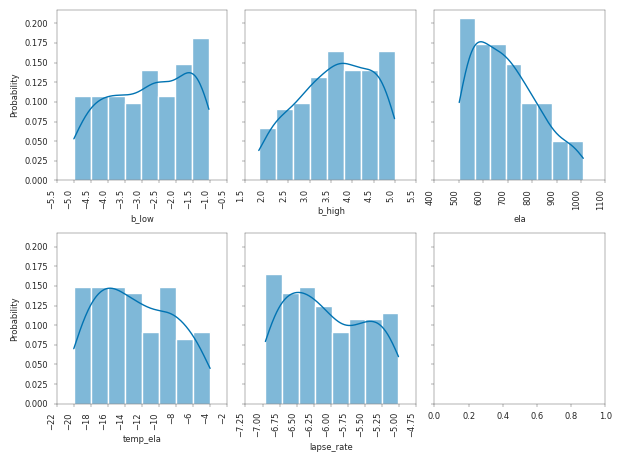

In [110]:
with sns.axes_style("ticks"):
    sns_cmap = sns.color_palette("colorblind")
    fig, axs = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=[6.2, 4.6])
    fig.subplots_adjust(bottom=0, top=1, left=0, right=1, wspace=-1, hspace=-1)
    for k, v in enumerate(["b_low", "b_high", "ela", "temp_ela", "lapse_rate"]):
        sns.histplot(data=too_big_glaciers_df, x=v, kde=True,
                     color=sns_cmap[0],
                     stat="probability", ax=axs.ravel()[k])
        axs.ravel()[k].set_xticks(axs.ravel()[k].get_xticks(), 
                                  axs.ravel()[k].get_xticklabels(), 
                                  rotation=90, ha='right')

fig.tight_layout()
fig.savefig("2023_06_23_uq_climate_flow/kennicott_too_big_hists.pdf")